## Problem 6

Estimate the two-dimensional configuration that minimizes the potential energy of three particles,

$$
\Phi(\boldsymbol{r}_1, \boldsymbol{r}_2, \boldsymbol{r}_3) = 4 \left( \frac{1}{r_{12}^{12}} - \frac{1}{r_{12}^{6}} \right) + 4 \left( \frac{1}{r_{23}^{12}} - \frac{1}{r_{23}^{6}} \right) + 4 \left( \frac{1}{r_{13}^{12}} - \frac{1}{r_{13}^{6}} \right)
$$

corresponding to a pair interaction according to the dimensionless Lennard-Jones potential, where

$$
r_{ij} := |\boldsymbol{r}_i - \boldsymbol{r}_j|
$$

is the distance between particles $i$ and $j$. To minimize this function, use the **simulated annealing** method, considering that the particles are confined within a disk of radius $R=5$ and origin $(0,0)$.


In [208]:
import numpy as np
import math 
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [209]:
#Set Up of the Problem
R = 5 # Radius of the confining disk
Tem_initial = 10  # Initial temperature for simulated annealing
Min_Tem = 1e-4  # Final temperature for simulated annealing
Cooling_rate = 0.995  # Cooling rate for simulated annealing
step_size_initial = 0.5 # Initial step size for particle movement
iterations_per_temp = 1000 # Number of iterations at each temperature
seed = None  # Random seed for reproducibility
eps = 1e-12 # small value to avoid division by zero

In [210]:
#Function definitions
def sample_initial_positions(R):
    #sample initial positions of the three particles within the disk of radius R
    u = random.uniform(0, 1)
    r = R* math.sqrt(u)
    theta = 2 * math.pi * random.random()
    return np.array([r * math.cos(theta), r * math.sin(theta)], dtype=float)


In [211]:
def projection_over_disk(xy, R):
    #project the position  if it is outside the disk
    r = math.hypot(xy[0], xy[1]) # calculate the distance from the origin
    if r <= R: #radial projection

        return xy
    

    return xy*((R - eps)/r)

In [212]:
def ij_pais_energy(r):
    r = max(r, eps) # avoid division by zero

    inv_r6 = (1/r)**6 # calculate 1/r^6

    inv_r12 = (inv_r6)**2 # calculate 1/r^12

    return 4*(inv_r12 - inv_r6)
    
    

In [213]:
def total_energy(positions):
    # we calculate the energy of the pairs
    r1,r2,r3 = positions
    r12 = np.linalg.norm(r1 - r2)
    r23 = np.linalg.norm(r2 - r3)
    r13 = np.linalg.norm(r1 - r3)
    return ij_pais_energy(r12 ) + ij_pais_energy(r23) + ij_pais_energy(r13)
    
    

In [214]:
def simulated_annealing_3particles(R, Temp_initial, Min_Tem, Cooling_rate,
                                  iterations_per_temp, step_size_initial, seed):

    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    current = np.vstack([sample_initial_positions(R) for _ in range(3)])
    current_E = total_energy(current)

    best = current.copy()
    best_E = current_E

    history_E = [current_E]
    history_best = [best_E]
    history_T = [Temp_initial]

    T = Temp_initial

    while T > Min_Tem:
        step = step_size_initial * (T / Temp_initial)

        for _ in range(iterations_per_temp):
            i = random.randrange(3)
            proposal = current.copy()

            dx = random.uniform(-step, step)
            dy = random.uniform(-step, step)

            proposal[i, 0] += dx
            proposal[i, 1] += dy
            proposal[i] = projection_over_disk(proposal[i], R)

            new_E = total_energy(proposal)
            dE = new_E - current_E

            accept = (dE <= 0.0) or (random.random() < math.exp(-dE / T))

            if accept:
                current = proposal
                current_E = new_E

                if current_E < best_E:
                    best = current.copy()
                    best_E = current_E

        history_E.append(current_E)
        history_best.append(best_E)
        history_T.append(T)

        T *= Cooling_rate

    return best, best_E, history_E, history_best, history_T


#simulation!!!!!
best,best_E, history_E, history_best, history_T = simulated_annealing_3particles(R, Tem_initial, Min_Tem, Cooling_rate,
                                  iterations_per_temp, step_size_initial, seed)
print("-----------RESULTS-----------")
print(f"Best Energy Found = {best_E}")
#print(f"Best Positions:\n{best} ")
print("Best Positions (x, y):")
for i in range(3):
    # we access the positions of each particle

    print(f"r{i+1} = {best[i, 0]:.3f}, {best[i, 1]:.3f}")
print("\n----Geometric Validation----")
d12 = np.linalg.norm(best[0] - best[1])
d23 = np.linalg.norm(best[1] - best[2])
d13 = np.linalg.norm(best[0] - best[2])
print(f"Distance r1-r2: {d12:.3f}")
print(f"Distance r2-r3: {d23:.3f}")
print(f"Distance r1-r3: {d13:.3f}")
  

-----------RESULTS-----------
Best Energy Found = -2.9999986985062512
Best Positions (x, y):
r1 = 0.511, 3.355
r2 = 0.981, 2.335
r3 = -0.137, 2.437

----Geometric Validation----
Distance r1-r2: 1.123
Distance r2-r3: 1.123
Distance r1-r3: 1.123


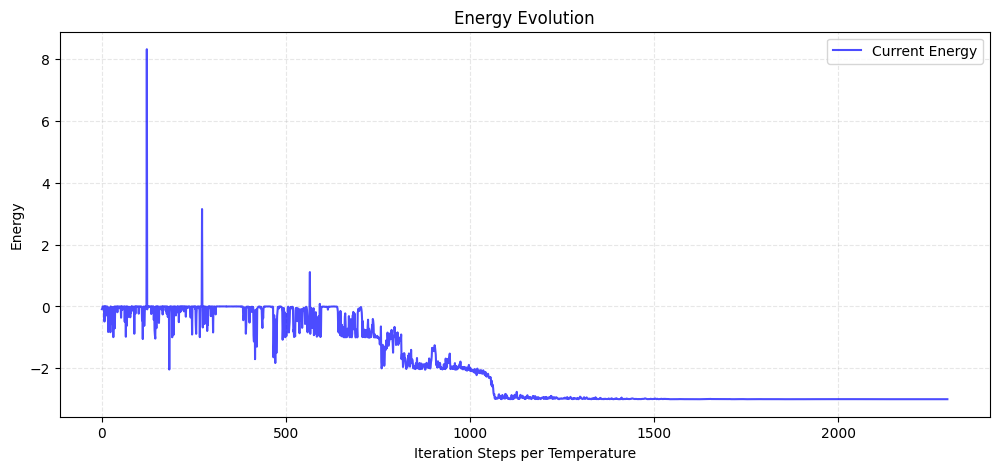

In [215]:
#Now the plots!!!!
plt.figure(figsize=(12, 5))
plt.plot(history_E,'b-', label='Current Energy', alpha=0.7) #plot the energy histogram
plt.xlabel('Iteration Steps per Temperature')
plt.ylabel('Energy')
plt.title('Energy Evolution')
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend()
plt.show()


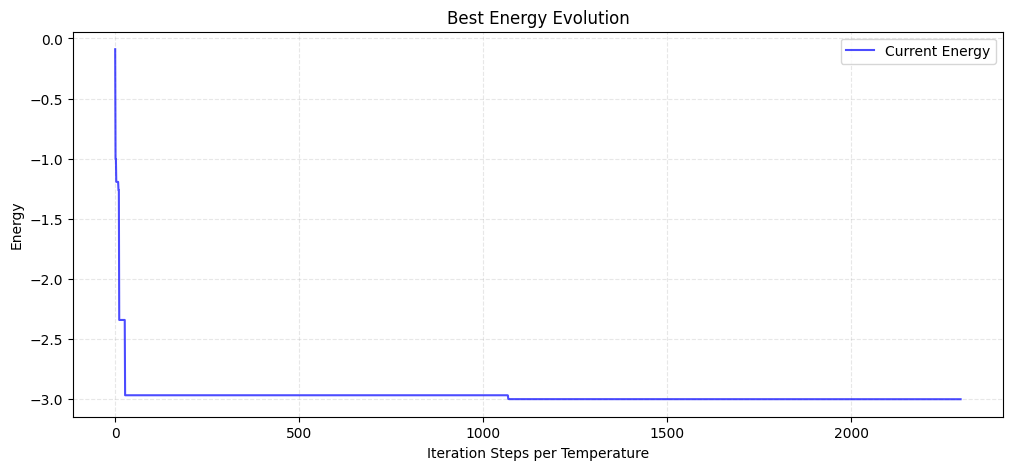

In [216]:
# Plot best energy history
plt.figure(figsize=(12, 5))
plt.plot (history_best,'b-', label='Current Energy', alpha=0.7)
plt.xlabel('Iteration Steps per Temperature')
plt.ylabel('Energy')
plt.title('Best Energy Evolution')
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend()
plt.show()


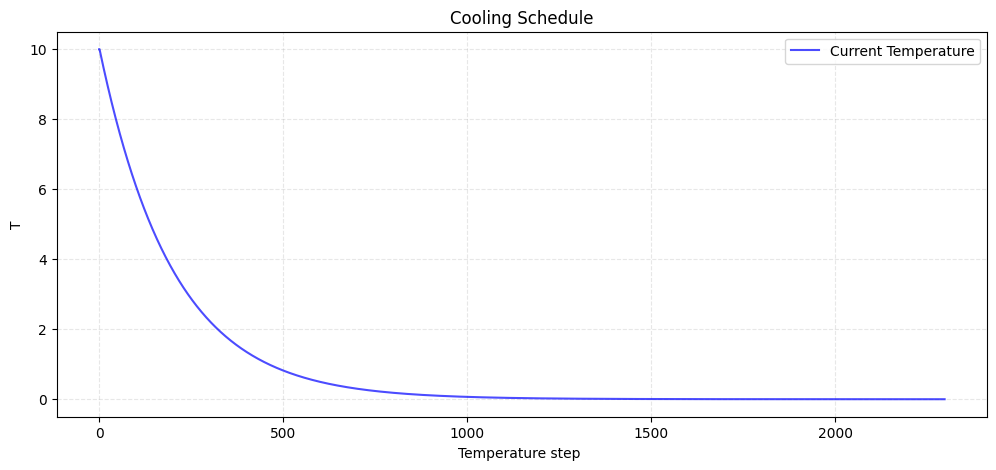

In [217]:
# Plot temperature history
plt.figure(figsize=(12, 5))
plt.plot (history_T,'b-', label='Current Temperature', alpha=0.7)
plt.xlabel('Temperature step ')
plt.ylabel('T')
plt.title('Cooling Schedule')
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend()
plt.show()

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


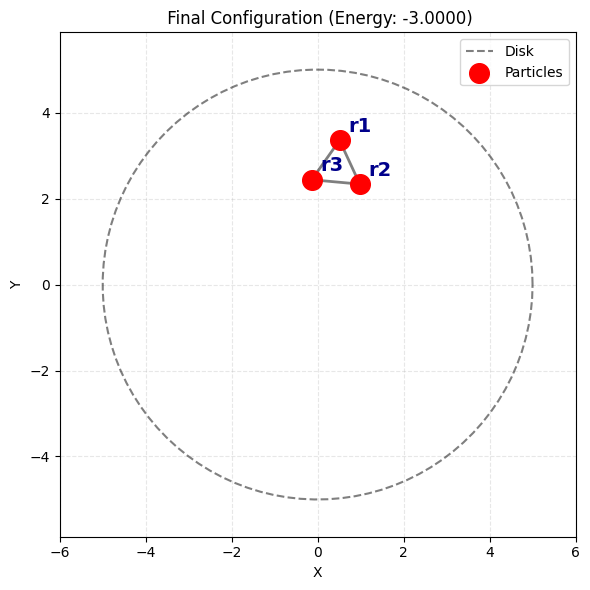

In [218]:
# Disk-Plot

plt.figure(figsize=(6, 6)) 

#We define the disk
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(R * np.cos(theta), R * np.sin(theta), 'k--', alpha=0.5, label='Disk')

# Plot the particles 
plt.scatter(best[:, 0], best[:, 1], c='red', s=200, zorder=5, label='Particles')
pairs = [(0, 1), (1, 2), (0, 2)]

# Draw the lines between particles
for i, j in pairs:
    # line particle i to j
    x_pair = [best[i, 0], best[j, 0]]
    y_pair = [best[i, 1], best[j, 1]]
    plt.plot(x_pair, y_pair, 'black', alpha=0.5, linewidth=2)
names = ["r1", "r2", "r3"]
for i in range(3):
    # we get the coordinates of x, of our particle i
    x = best[i, 0]
    y = best[i, 1]
    
    
    plt.text(x + 0.2, y + 0.2, names[i], fontsize=14, fontweight='bold', color='darkblue')
# Labels and aesthetics
plt.title(f' Final Configuration (Energy: {best_E:.4f})')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal') 
plt.grid(True, linestyle='--', alpha=0.3)
plt.xlim(-R - 1, R + 1)
plt.ylim(-R - 1, R + 1)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

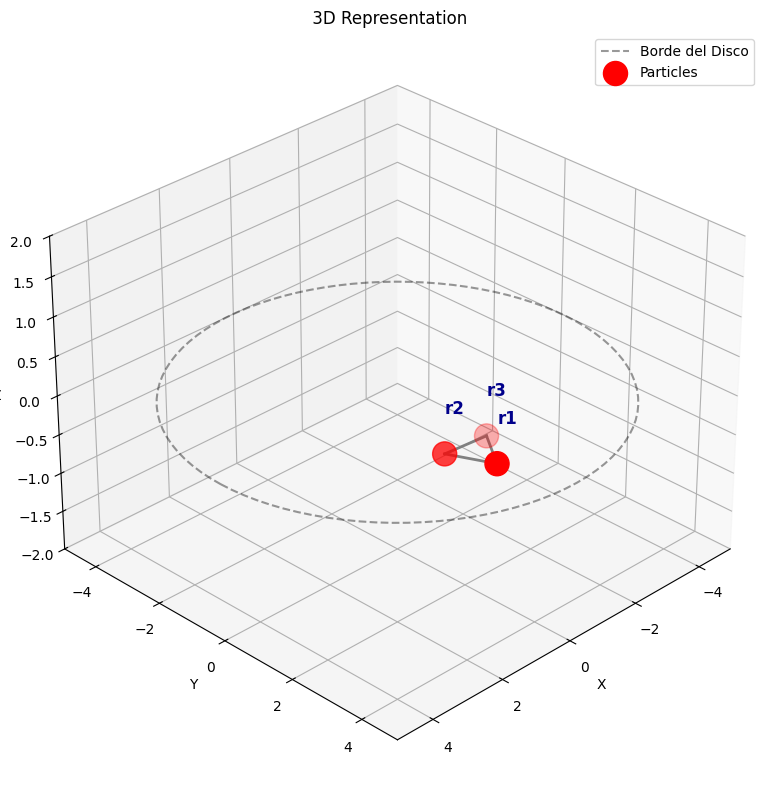

In [219]:
# 3D Ploting (BONUS)
from mpl_toolkits.mplot3d import Axes3D

# Make the 3D figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the disk (Disk in Z=0)
theta = np.linspace(0, 2*np.pi, 100)
x_circ = R * np.cos(theta)
y_circ = R * np.sin(theta)
z_circ = np.zeros_like(x_circ) #  Z=0

ax.plot(x_circ, y_circ, z_circ, 'k--', alpha=0.4, label='Borde del Disco')

# Plot the particles
# Z=0 for all the partiples (we can give them some height if we want)
z_vals = np.zeros(3)
ax.scatter(best[:, 0], best[:, 1], z_vals, c='red', s=300, depthshade=True, label='Particles')

# Plot the connections betweens the particles
pairs = [(0, 1), (1, 2), (0, 2)]
for i, j in pairs:
    x_line = [best[i, 0], best[j, 0]]
    y_line = [best[i, 1], best[j, 1]]
    z_line = [0, 0] #  Z=0
    ax.plot(x_line, y_line, z_line, color='gray', linewidth=2)

# 4. Labels in 3D
nombres = ["r1", "r2", "r3"]
for i in range(3):
   
    ax.text(best[i, 0], best[i, 1], 0.5, nombres[i], fontsize=12, fontweight='bold', color='darkblue')

# 5. Configurarion of the AXIS 
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f' 3D Representation')

# Limits
ax.set_xlim(-R, R)
ax.set_ylim(-R, R)
ax.set_zlim(-2, 2) 

ax.view_init(elev=30, azim=45) 


plt.legend()
plt.tight_layout()
plt.show()